In [1]:

"""

"""

import SimPEG.PF as PF
from SimPEG import *
from SimPEG.Utils import io_utils
import matplotlib
import time as tm
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import NearestNDInterpolator
from sklearn.mixture import GaussianMixture
import numpy as np
import copy
import pickle
from pymatsolver import PardisoSolver
import seaborn
import sys
sys.path.append('../')
from DO27_Utils import *

# Nicer plots
seaborn.set()
matplotlib.rcParams['font.size'] = 14

# Reproducible Science
np.random.seed(518936)

mesh = Mesh.load_mesh('../Forward/mesh_inverse')
# Define no-data-value
ndv = -100

model_dir = '../Geology_Surfaces/'

# # Load topography file in UBC format and find the active cells
# Import Topo
topofile = model_dir + 'TKCtopo.dat'
topo = np.genfromtxt(topofile, skip_header=1)
# Find the active cells
actv = Utils.surface2ind_topo(mesh, topo, gridLoc='N')
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, ndv)
print("Active cells created from topography!")

# Load Data
survey_grav = io_utils.readUBCgravityObservations(
    "../Forward/GRAV_noisydata.obs"
)
survey_grav.eps = 0.
survey_mag, _ = io_utils.readUBCmagneticsObservations(
    "../Forward/MAG_noisydata.obs"
)
survey_mag.eps = 0.


# Load ground-truth for comparison
model_grav = mesh.readModelUBC(
    '../Forward/model_grav.den'
)
model_grav = model_grav[model_grav != -100.]

model_mag = mesh.readModelUBC(
    '../Forward/model_mag.sus'
)
model_mag = model_mag[model_mag != -100.]

# Load petrophysics
clfref = pickle.load(open('../Petrophysics/gmm_density_magsus_2clusters.p','rb'))
n = clfref.n_components

# Wires mapping
wires = Maps.Wires(('den', actvMap.nP), ('sus', actvMap.nP))
gravmap = actvMap * wires.den
magmap = actvMap * wires.sus

# Grav problem
# Creat reduced identity map
nactv = np.int(np.sum(actv))
idenMap = Maps.IdentityMap(nP=nactv)
# Create the forward model operator
prob_grav = PF.Gravity.GravityIntegral(mesh, rhoMap=wires.den, actInd=actv)
# Pair the survey and problem
survey_grav.pair(prob_grav)

# If you formed the sensitivity gravity matrix before, you can load it here
#Ggrav = np.load('../Forward/G_Grav_Inverse.npy')
#prob_grav._G = -Ggrav
#prob_grav.Solver = PardisoSolver

# Mag problem
# Create the forward model operator
prob_mag = PF.Magnetics.MagneticIntegral(mesh, chiMap=wires.sus, actInd=actv)
# Pair the survey and problem
survey_mag.unpair()
survey_mag.pair(prob_mag)
# If you formed the sensitivity magnetic matrix before, you can load it here
#Gmag = np.load('../Forward/G_Mag_Inverse.npy')
#prob_mag._G = Gmag
#prob_mag.Solver = PardisoSolver

# Data Misfit
dmis_grav = DataMisfit.l2_DataMisfit(survey_grav)
wd_grav = np.ones_like(survey_grav.dobs) * 0.01
dmis_grav.W = 1 / wd_grav

dmis_mag = DataMisfit.l2_DataMisfit(survey_mag)
wd_mag = np.ones_like(survey_mag.dobs) * 1.
dmis_mag.W = 1 / wd_mag

dmis = dmis_grav + dmis_mag

# Initial Model
m0 = np.r_[-1e-4 * np.ones(actvMap.nP), 1e-4 * np.ones(actvMap.nP)]

# Sensitivity weighting
wr_grav = np.sum(prob_grav.G**2., axis=0)**0.5
wr_grav = (wr_grav / np.max(wr_grav))

wr_mag = np.sum(prob_mag.G**2., axis=0)**0.5
wr_mag = (wr_mag / np.max(wr_mag))

# Regularization
reg = Regularization.MakeSimplePetroRegularization(
    GMmref=clfref,
    GMmodel=clfref,
    mesh=mesh,
    wiresmap=wires,
    maplist=[idenMap, idenMap],
    mref=m0,
    indActive=actv,
    alpha_s=1.0, alpha_x=1.0, alpha_y=1.0, alpha_z=1.0,
    alpha_xx=0., alpha_yy=0., alpha_zz=0.,
    cell_weights_list=[wr_grav, wr_mag]
)
reg.objfcts[0].mrefInSmooth = False
reg.objfcts[0].approx_gradient = True
reg.objfcts[0].objfcts[0].evaltype = 'approx'

# Optimization
lowerbound = np.r_[-2. * np.ones(actvMap.nP), 0. * np.ones(actvMap.nP)]
upperbound = np.r_[0. * np.ones(actvMap.nP), 1e-1 * np.ones(actvMap.nP)]
opt = Optimization.ProjectedGNCG(
    maxIter=30,
    lower=lowerbound, upper=upperbound,
    maxIterLS=20,
    maxIterCG=100, tolCG=1e-4
)
# Inverse problem
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

# Add directives to the inversion
alpha0_ratio = np.r_[np.zeros(len(reg.objfcts[0].objfcts)),
                     0.5 * 1e-2 * np.r_[0.,2.,2.,2] * np.ones(len(reg.objfcts[1].objfcts)),
                     0.5 * 40. * 1e-2 * np.r_[0.,2.,2.,2] * np.ones(len(reg.objfcts[2].objfcts))]

# Set smoothness scales
Alphas = Directives.AlphasSmoothEstimate_ByEig(
    alpha0_ratio=alpha0_ratio,
    ninit=10, verbose=True
)

# Beta Initialization
beta = Directives.BetaEstimate_ByEig(beta0_ratio=1., ninit=10)

# Beta schedule
betaIt = Directives.PetroBetaReWeighting(
    verbose=True, rateCooling=2., rateWarming=1.,
    tolerance=0., UpdateRate=1,
    ratio_in_cooling=False,
    progress=0.2,
    update_prior_confidence=False,
    progress_gamma_cooling=1.,
    ratio_in_gamma_cooling=False,
    alphadir_rateCooling=1.,
    kappa_rateCooling=1.,
    nu_rateCooling=1.,
)

# Target misfits
targets = Directives.PetroTargetMisfit(
    verbose=True,
    chiSmall=1.
)

# Add mref to smooth once stable
MrefInSmooth = Directives.AddMrefInSmooth(
    wait_till_stable=True,
    verbose=True,
)

# Update the GMM, mref and Ws
petrodir = Directives.GaussianMixtureUpdateModel(
    keep_ref_fixed_in_Smooth=True,
    verbose=False,
    update_covariances=True,
    alphadir=1, # update the proportions
    kappa=np.c_[1e8,0].T, # update the mean of the kimberlite but keep the bckgrd constant
    nu=1e8 # fixed covariances
)

# Pre-conditioner
update_Jacobi = Directives.UpdatePreconditioner()

# Scale the geophysical data misfits
ScalingJoint = Directives.ScalingEstimate_ByEig(
    ninit=10, verbose=True, Chi0=np.r_[1., 40.])

# Inverse problem with directives
inv = Inversion.BaseInversion(
    invProb,
    directiveList=[
        ScalingJoint, Alphas, beta,
        petrodir, targets,
        betaIt, MrefInSmooth, update_Jacobi
    ]
)


Active cells created from topography!
Begin linear forward calculation: 
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Linear forward calculation ended in: 791.4385161399841 sec
Begin forward: M=H0, Rx type= tmi
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %


In [2]:
clfref.covariances_

array([[2.00e-04, 1.25e-07],
       [8.00e-04, 5.00e-07]])

In [3]:
mcluster = inv.run(m0)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver and solverOpts as the GravityIntegral problem***
Scale Multipliers:  [0.73895244 0.26104756]
Alpha scales:  [1, 1, 1]
Alpha scales:  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Alpha scales:  [0.0, 148202.03478034594, 148453.79747526697, 147868.97045444066]
Alpha scales:  [0.0, 7081427.581260297, 7062974.45081873, 7723401.011093844]
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.51e-01  3.35e+06  0.00e+00  3.35e+06    1.23e+03      0              
DM:  [414547.65288805  51676.8162737 ] [False False] ; CL:  859936.7742680986 False ; DP:  True ; All:

DM:  [473.66238342 630.03150843] [ True False] ; CL:  418852.273826579 False ; DP:  True ; All: False
progress [473.66238342 630.03150843] >< [480.5 480.5]
update beta for countering plateau
mref changes in  0  places
  25  8.80e-04  5.14e+02  2.47e+06  2.69e+03    1.03e+02      0              
DM:  [176.10549427 292.55653099] [ True  True] ; CL:  446092.9463068909 False ; DP:  True ; All: False
progress [176.10549427 292.55653099] >< [480.5        504.02520675]
update alpha_s for clustering:  156.0682349843721
mref changes in  0  places
add mref to Smoothness. Percent_diff is  0.0
  26  8.80e-04  2.07e+02  6.21e+06  5.67e+03    1.41e+02      0              
DM:  [849.93431906 485.84326586] [False False] ; CL:  330515.7274817174 True ; DP:  True ; All: False
progress [849.93431906 485.84326586] >< [480.5 480.5]
update beta for countering plateau
mref changes in  0  places
  27  4.40e-04  7.55e+02  4.03e+06  2.53e+03    7.87e+01      0              
DM:  [235.56304357 438.26860382] [ Tr

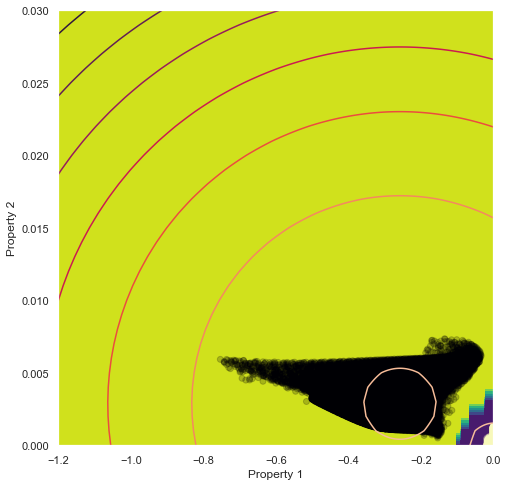

In [4]:
# Learned GMM during the inversion process
mcluster = invProb.model
x, y = np.mgrid[-1.201:0.1:.001, -0.01:0.0301:.001]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
rv = invProb.reg.objfcts[0].GMmodel.score_samples(pos.reshape(-1, 2))
rvm = invProb.reg.objfcts[0].GMmodel.predict(pos.reshape(-1, 2))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.contourf(x, y, rvm.reshape(x.shape),cmap='viridis')
ax.contour(x, y, rv.reshape(x.shape))
ax.scatter(wires.den * mcluster, wires.sus * mcluster,
           c=invProb.reg.objfcts[0].membership(invProb.reg.objfcts[0].mref), cmap='magma_r', alpha=0.2)

ax.set_xlabel('Property 1')
ax.set_xlim(-1.2, 0.)
ax.set_ylim(-0.00, 0.03)
ax.set_ylabel('Property 2')
ax.set_aspect(40)

plt.show()

..\DO27_Utils.py:34: RuntimeWarning: invalid value encountered in greater
  TargetF_Ind = np.where(np.abs(modGrad) > 0)[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


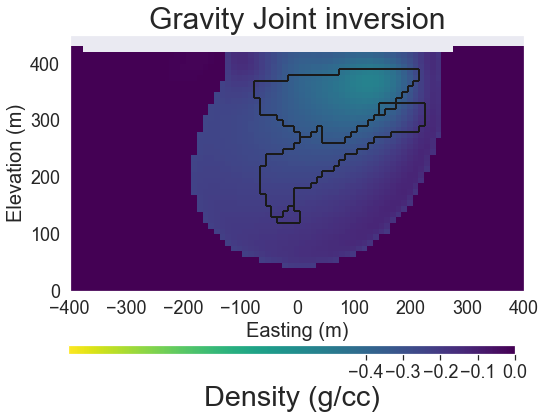

In [5]:
seaborn.set(font='sans-serif')
seaborn.set_style('darkgrid', {'legend.frameon':True})
vmin_grav, vmax_grav = -1.2, 0.0
vmin_mag, vmax_mag = 0, 0.02
fontsize=18
indx = 46
normal = 'Y'
nax=1

geomodel = mesh.readModelUBC("../Forward/geomodel")
geomodel[geomodel==-100] = np.nan
gravjoint = gravmap*mcluster
gravjoint[np.isnan(geomodel)] = np.nan

mesh_plot = Mesh.TensorMesh([mesh.hx, mesh.hy, mesh.hz], x0="CCN")
mesh_plot.x0[-1] = mesh.x0[-1]
fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=False, sharey=False)
fig.subplots_adjust(wspace=0.,hspace=0.)
ax = np.array([ax])

#Grav L2
gravplot = mesh_plot.plotSlice(
    gravjoint, ax=ax[0], normal=normal,ind=indx,
    clim = [vmin_grav, vmax_grav], pcolorOpts = {'cmap':'viridis_r'})
ax[0].set_aspect('equal')
ax[0].set_title('Gravity Joint inversion', fontsize=1.25*fontsize*(4./3.))
ax[0].set_xlabel('Easting (m)', fontsize=20)
ax[0].set_ylabel('Elevation (m)', fontsize=20)   
getBlkOutline(geomodel,mesh_plot,indx,normal, ax[0])

for i in range(len(ax)):
        ax[i].set_xlim([-400,400])
        ax[i].set_ylim([0.,450])
        ax[i].tick_params(labelsize=18)
        
cbaxes_grav = fig.add_axes([0.2, 0, 0.62, 0.025]) 
cbargrav = fig.colorbar(gravplot[0],cbaxes_grav, orientation='horizontal', ticks=np.r_[-0.4,-0.3,-0.2,-0.1,0.])
cbargrav.ax.tick_params(labelsize=18)
cbargrav.set_label("Density (g/cc)",fontsize=1.2*fontsize*(4./3.))
cbargrav.ax.xaxis.set_label_position('bottom')

plt.tight_layout()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


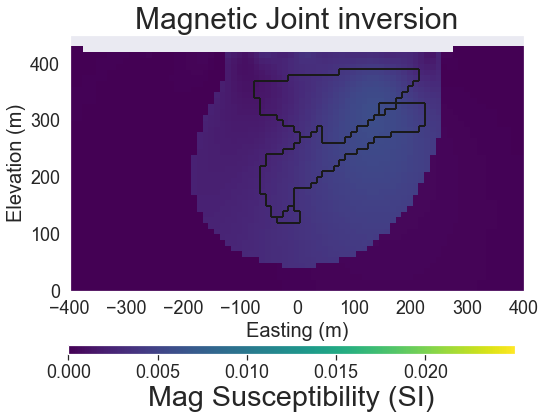

In [6]:
seaborn.set(font='sans-serif')
seaborn.set_style('darkgrid', {'legend.frameon':True})
vmin_grav, vmax_grav = -0.4, 0.0
vmin_mag, vmax_mag = 0, 0.025
fontsize=18
indx = 46
normal = 'Y'
nax=1

magjoint = magmap*mcluster
magjoint[np.isnan(geomodel)] = np.nan

mesh_plot = Mesh.TensorMesh([mesh.hx, mesh.hy, mesh.hz], x0="CCN")
mesh_plot.x0[-1] = mesh.x0[-1]
fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=False, sharey=False)
fig.subplots_adjust(wspace=0.,hspace=0.)
ax = np.array([ax,ax,ax])

#Mag petro
magplot = mesh_plot.plotSlice(
    magjoint, ax=ax[2], normal=normal,ind=indx,
    clim = [vmin_mag, vmax_mag], pcolorOpts = {'cmap':'viridis'})
ax[2].set_aspect('equal')
ax[2].set_title('Magnetic Joint inversion', fontsize=1.25*fontsize*(4./3.))
ax[2].set_xlabel('Easting (m)', fontsize=20)
ax[2].set_ylabel('Elevation (m)', fontsize=20)
getBlkOutline(geomodel,mesh_plot,indx,normal, ax[2])

for i in range(len(ax)):
        ax[i].set_xlim([-400,400])
        ax[i].set_ylim([0.,450])
        ax[i].tick_params(labelsize=18)

cbaxes_mag = fig.add_axes([.2, 0.0, 0.62, 0.025]) 
cbarmag = fig.colorbar(magplot[0],cbaxes_mag, orientation='horizontal', ticks=np.r_[0.,0.005,0.01,0.015,0.02])
cbarmag.ax.tick_params(labelsize=18)
cbarmag.set_label("Mag Susceptibility (SI)",fontsize=1.2*fontsize*(4./3.))
cbarmag.ax.xaxis.set_label_position('bottom')

plt.tight_layout()